# Dog Breed Identification - Kaggle competition

## Init

* Load the training set.
* View a couple of images.
* Create a one layer model.
* Get a place on the leaderboard.

In [1]:
import os
import random
import fnmatch
from shutil import copyfile, rmtree
import csv

import pandas
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16
from keras.models import Model

%matplotlib inline

Using TensorFlow backend.


In [2]:
def to_plot(img):
    return np.rollaxis(img, 0, 1).astype(np.uint8)


def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    """Taken from Fast.ai utils."""
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
        
def get_steps(gen):
    """
    Generally define an epoch as an entire pass through the dataset.
    
    Therefore, we say that steps per epoch = num samples / batch size.
    """
    return gen.samples / gen.batch_size

### Prepare training set

In [3]:
labels = pandas.read_csv('data/labels.csv')

In [4]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,04e3bb77c15c18fc1ac101d86d612f46,scottish_deerhound
freq,1,126


Thinking a 90/10 training/dev split = 900 in the dev set.

Time to get it into a format that Keras likes.

In [5]:
if os.path.exists('./data/prepared'):
    rmtree('./data/prepared')

for label in labels.breed.unique():
    os.makedirs(f'./data/prepared/train/{label}', exist_ok=True)
    os.makedirs(f'./data/prepared/dev/{label}', exist_ok=True)
    os.makedirs(f'./data/prepared/sample/{label}', exist_ok=True)

for _, item_id, label in labels.itertuples():
    is_dev = random.random() > 0.9
    is_sample = random.random() > 0.85
    
    which_set = 'dev' if is_dev else 'train'
    copyfile(
        f'./data/train/{item_id}.jpg',
        f'./data/prepared/{which_set}/{label}/{item_id}.jpg')
    
    if is_sample:
        copyfile(
        f'./data/train/{item_id}.jpg',
        f'./data/prepared/sample/{label}/{item_id}.jpg')

In [5]:
_gen = ImageDataGenerator().flow_from_directory('./data/prepared/train', batch_size=4, class_mode='sparse')
x_batch, y_batch = next(_gen)

Found 9190 images belonging to 120 classes.


In [6]:
label_to_id = {id: label for label, id in _gen.class_indices.items()}

In [7]:
titles = [label_to_id[i] for i in y_batch]

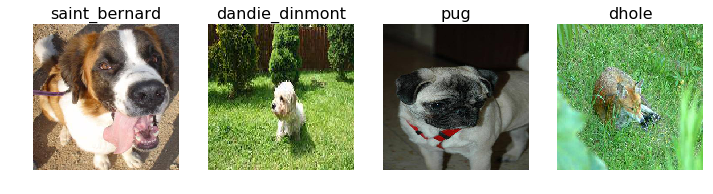

In [9]:
plots(x_batch, titles=titles)

### Create baseline model

In [10]:
print("Image size:", x_batch.shape)

Image size: (4, 256, 256, 3)


In [11]:
model = Sequential([
    BatchNormalization(input_shape=(256, 256, 3)),
    Flatten(),
    Dense(_gen.num_class, activation='softmax')])

model.compile(
    optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
gen = ImageDataGenerator()

In [13]:
train_gen = gen.flow_from_directory('./data/prepared/sample')
dev_gen = gen.flow_from_directory('./data/prepared/dev')

Found 1539 images belonging to 120 classes.
Found 1032 images belonging to 120 classes.


In [13]:
model.fit_generator(train_gen, epochs=2, steps_per_epoch=train_gen.samples, validation_data=dev_gen, validation_steps=dev_gen.samples)

Epoch 1/2
1539/1539 [==============================] - 331s - loss: 15.5621 - acc: 0.0338 - val_loss: 15.8312 - val_acc: 0.0174
Epoch 2/2
1539/1539 [==============================] - 328s - loss: 15.6252 - acc: 0.0304 - val_loss: 15.8055 - val_acc: 0.0194


Random accuracy would be around 0.0083 (120/1), so it's twice as good as random. Not great though. Doesn't appear to be getting any better either.

Few predict examples:

In [27]:
labels = []
for img_id in np.argmax(model.predict_generator(train_gen, 10), 1)[:10]:
    labels.append(label_to_id[img_id])
    
print(labels)

['maltese_dog', 'maltese_dog', 'maltese_dog', 'chow', 'chow', 'old_english_sheepdog', 'miniature_pinscher', 'norfolk_terrier', 'german_short-haired_pointer', 'old_english_sheepdog']


Seems to be predicting a lot of the same thing. Maybe try lowering the learning rate?

In [28]:
model = Sequential([
    BatchNormalization(input_shape=(256, 256, 3)),
    Flatten(),
    Dense(_gen.num_class, activation='softmax')])

model.compile(
    optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.fit_generator(train_gen, epochs=2, steps_per_epoch=train_gen.samples, validation_data=dev_gen, validation_steps=dev_gen.samples)

Epoch 1/2
1539/1539 [==============================] - 328s - loss: 0.4968 - acc: 0.9164 - val_loss: 5.5184 - val_acc: 0.1716
Epoch 2/2
1539/1539 [==============================] - 325s - loss: 0.0069 - acc: 1.0000 - val_loss: 5.8225 - val_acc: 0.1706


Much better. 20x better than random and overfitting like a boss. See where that gets me.

In [32]:
test_gen = gen.flow_from_directory('./data/test', batch_size=1, class_mode=None)

Found 10357 images belonging to 1 classes.


In [34]:
predictions = model.predict_generator(test_gen, steps=test_gen.samples)

In [41]:
def generate_submission(predictions, gen, output_file='sub.csv'):  
    fh = open(output_file, 'w')
    writer = csv.writer(fh)
    writer.writerow(['id'] + [i[1] for i in sorted(label_to_id.items(), key=lambda x: x[0])])
    for filename, prediction in zip(gen.filenames, predictions):
        dog_id = filename.split('/')[-1].split('.')[0]
        writer.writerow([dog_id] + list(prediction))
    fh.close()

In [42]:
generate_submission(predictions, test_gen)

That puts me at position 112, 3 away from the very bottom.

### L2 regularisation

In [44]:
model = Sequential([
    BatchNormalization(input_shape=(256, 256, 3)),
    Flatten(),
    Dense(_gen.num_class, activation='softmax', kernel_regularizer=l2(0.01))])

model.compile(
    optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
model.fit_generator(train_gen, epochs=2, steps_per_epoch=train_gen.samples, validation_data=dev_gen, validation_steps=dev_gen.samples)

Epoch 1/2
1539/1539 [==============================] - 331s - loss: 2.8140 - acc: 0.9167 - val_loss: 7.6600 - val_acc: 0.1749
Epoch 2/2
1539/1539 [==============================] - 328s - loss: 1.9881 - acc: 0.9967 - val_loss: 7.9553 - val_acc: 0.1738


Helped with overfitting a tiny bit but hasn't added much to the performance. Let's see what val accuracy we can get with the whole set.

In [46]:
train_gen = gen.flow_from_directory('./data/prepared/train')

Found 9190 images belonging to 120 classes.


In [51]:
model.fit_generator(train_gen, epochs=2, steps_per_epoch=train_gen.samples, validation_data=dev_gen, validation_steps=dev_gen.samples)

Epoch 1/2
9190/9190 [==============================] - 1336s - loss: 1.1190 - acc: 0.9763 - val_loss: 7.5201 - val_acc: 0.0668
Epoch 2/2
9190/9190 [==============================] - 1332s - loss: 0.5899 - acc: 0.9775 - val_loss: 7.1179 - val_acc: 0.0505


Much better. VGG16 next.

Loss is coming down but accuracy sucks. Sup with that?

In [52]:
predictions = model.predict_generator(test_gen, steps=test_gen.samples)

In [53]:
generate_submission(predictions, test_gen, 'sub_l2.csv')

## VGG16

### Retrain dense layers

Going to load VGG16 from Keras and retrain just the fully-connected layers. Will consider retraining some of the later conv layers if that helps.

In [8]:
gen = ImageDataGenerator()

In [9]:
train_gen = gen.flow_from_directory('./data/prepared/sample', target_size=(224, 224))
dev_gen = gen.flow_from_directory('./data/prepared/dev', target_size=(224, 224))

Found 1539 images belonging to 120 classes.
Found 1032 images belonging to 120 classes.


In [10]:
vgg16_conv = VGG16(weights='imagenet', include_top=True)

In [11]:
vgg16_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [12]:
for layer in vgg16_conv.layers:
    layer.trainable = False

In [13]:
x = Dense(train_gen.num_class, activation='softmax', name='predictions')(
    vgg16_conv.layers[-2].output)

model = Model(inputs=vgg16_conv.input, outputs=x)
model.compile(
    optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
model.fit_generator(train_gen, epochs=2, steps_per_epoch=train_gen.samples, validation_data=dev_gen, validation_steps=dev_gen.samples)

Epoch 1/2
1539/1539 [==============================] - 1179s - loss: 0.3478 - acc: 0.9568 - val_loss: 3.0308 - val_acc: 0.4800
Epoch 2/2
 217/1539 [===>..........................] - ETA: 607s - loss: 0.1470 - acc: 0.9909

In [ ]:
predictions = model.predict_generator(test_gen, steps=test_gen.samples, 'sub3.csv')